In [1]:
######################################################################
######################################################################
###### WRITTEN BY NEHA HUNKA, NHUNKA@UMD.EDU #########################
######################################################################
######################################################################

# This notebook shows how to integrate Sudan NFI-estimated AGBD and Volume, 
# Forest probability map and GEDI Forest Height estimates (see https://glad.umd.edu/dataset/gedi). 
# It relies on the computational power of the INLA Package in R (https://www.r-inla.org/).  

################################# ################################# #############################
################################# Geostatistical Model-based Estimation #########################
################################# ################################# #############################

# Please refer to code "GMB_Sudan_MODEL.R"
# In this script, we make predictions with the model at desired locations

############# AT THE START, WE INSTALL PACKAGES WE NEED ###############

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# install.packages("fmesher", dependencies = TRUE)
# install.packages("MatrixModels", type = "source")
# install.packages("exactextractr")
# install.packages("inlabru")
# install.packages("sn" ,dependencies = TRUE)
# packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
# package.check <- lapply(packages, FUN = function(x) {
#   if (!require(x, character.only = TRUE)) {
#     install.packages(x, dependencies = TRUE)
#     library(x, character.only = TRUE, quietly=TRUE)
#   }
# })
# Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

######################################################
############## LOAD PACKAGES #########################
######################################################

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")
library(gstat)

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
# library(exactextractr)

library(ggplot2)
library(viridis)
library(stringr)
# library(sn)

# setwd("/home/sepal-user/Sudan_2025_FRL")

Warning message:
“package ‘INLA’ was built under R version 4.4.2”
This is INLA_24.12.11 built 2024-12-11 19:58:26 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Linking to GEOS 3.12.1, GDAL 3.8.5, PROJ 9.4.0; sf_use_s2() is TRUE

terra 1.7.78


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required

Reading layer `ne_10m_admin_0_countries' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.80945 ymin: 8.681642 xmax: 38.60385 ymax: 22.22696
Geodetic CRS:  WGS 84


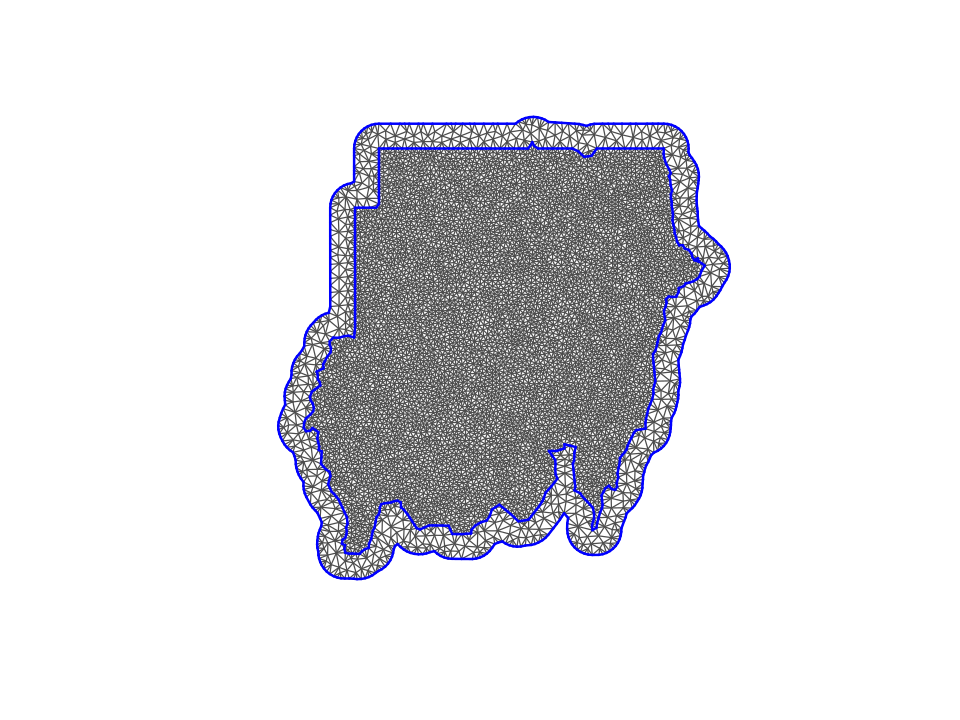

In [2]:
###################################################################
################ BEGIN MODELING - CREATE INLA MESH ################
###################################################################

options(repr.plot.width=8, repr.plot.height=6)
Sudan <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_Strata/Sudan_NE.gpkg")
Sudan <- Sudan %>% st_transform(crs=6933)

DATA <- read.csv("/projects/my-private-bucket/Data/NFI_data/Sudan/DATA.csv")
DATA <- DATA[DATA$gedi.agbd > 0,]
DATA <- DATA[DATA$AG_Biomass..Mg.ha. > 0,]
factor <- (1/3)
DATA$AG_Biomass..Mg.ha. <- (DATA$AG_Biomass..Mg.ha.)^factor

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
nfi.agbd <- DATA$AG_Biomass..Mg.ha. 
gedi.agbd <- DATA$gedi.agbd
FNF.prob <- DATA$FNF.prob

max.edge = 20*10^3
Sudan.buffer = st_buffer(Sudan, dist = max.edge*5) # We also make a 5 km buffer around Sudan to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Sudan, "Spatial"), as(Sudan.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
plot(mesh)

n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 

  |======================================================================| 100%


Cannot preload entire working area of 3120182231 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`).”


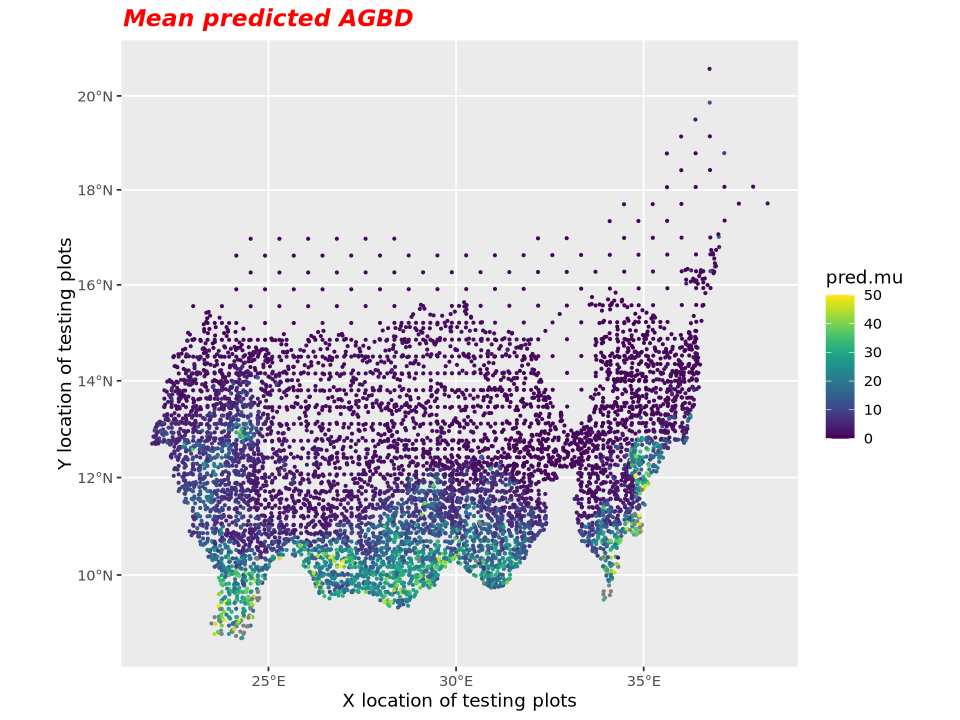

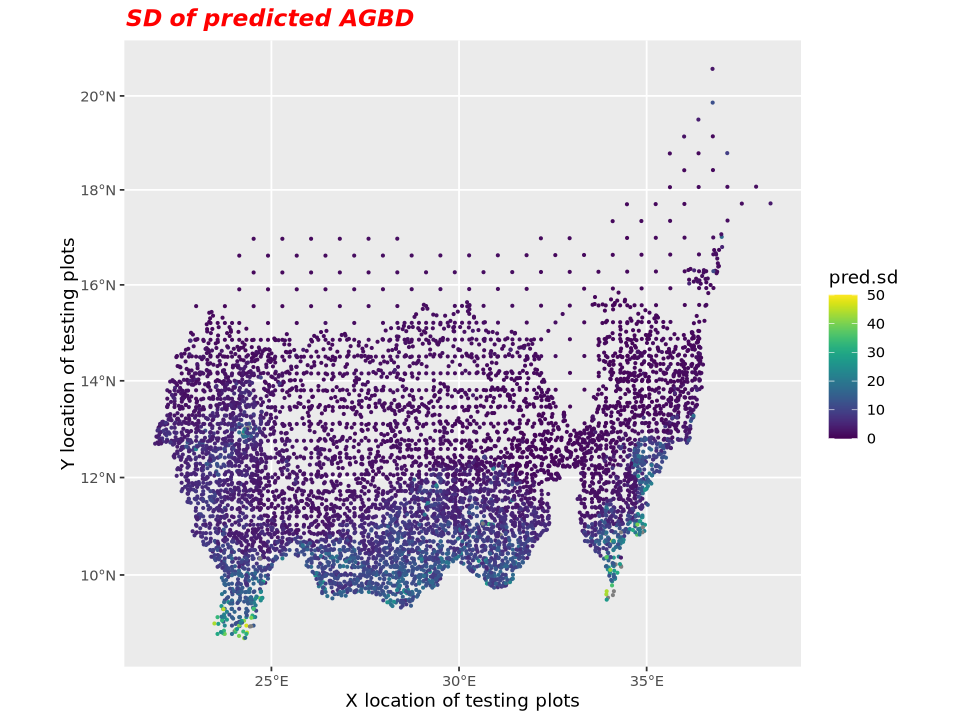

In [4]:
######################################################################
####### PREDICTIONS AT SITES OF PREFERED PLOTS REDONE ################
######################################################################
THRESHOLD_FOREST_PROBABILITY = 0

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan_6933.tif")
FNF <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_FNF_probability_2023_updated_6933.tif")

DEG <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/NFI_grid_sudan_CE_assessment.csv")
grid_to_predict <- st_as_sf(DEG, coords = c("location_x", "location_y"), crs = 4326) %>% st_transform("epsg:6933")
grid = as.data.frame(grid_to_predict %>% st_coordinates())

GEDI.pred = exactextractr::exact_extract(GEDI_L4A,st_buffer(grid_to_predict,250), 'mean')
grid$GEDI.pred <- GEDI.pred

FNF.pred = exactextractr::exact_extract(FNF,st_buffer(grid_to_predict,250), 'mean')
FNF.array <- FNF.pred
FNF.array[FNF.array<=THRESHOLD_FOREST_PROBABILITY] = 1 #NA (we want to prepare ALL degrdation sites, irrespective of FNF)
FNF.array[FNF.array>THRESHOLD_FOREST_PROBABILITY] = 1
grid$FNF.array = FNF.array

grid_original <- grid
grid <- grid[(!is.na(grid$FNF.array) & grid$GEDI.pred>0),]
DEG <- DEG[(!is.na(grid_original$FNF.array) & grid_original$GEDI.pred>0),]
grid_to_predict <- grid_to_predict[(!is.na(grid_original$FNF.array) & grid_original$GEDI.pred>0),]
loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

FNF.pred <- FNF.pred[(!is.na(FNF.array) & GEDI.pred>0)]
GEDI.pred <- GEDI.pred[(!is.na(FNF.array) & GEDI.pred>0)]

samples = inla.posterior.sample(n = 1000, result = model_fit) # Draw posterior samples from our model fit 
A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# Our model function
pred_fun = function(...){
  drop(intercept + 
         GEDI.pred*L4A +
         FNF.pred*FNF +
         A.pred%*%alpha.spat[1:k] +   
         Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k] + 
         Diagonal(x = FNF.pred)%*%A.pred%*%eta.spat[1:k]) +
    rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
pred.samples[pred.samples < 0] = 0

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, sd)

DEG['AGBD'] <- pred.mu
DEG['AGBD_SE'] <- pred.sd
write.csv(DEG,"/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/NFI_grid_sudan_CE_assessment_AGBD.csv",row.names=FALSE) #Save the data

ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(limits = c(0, 50)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("Mean predicted AGBD") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

ggplot() + coord_sf(crs = 6933) + 
  geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.sd),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
  scale_color_viridis(limits = c(0, 50)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("SD of predicted AGBD") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))

In [5]:
################################################################################
####### PREDICTIONS AT SITES OF NFI hypo and intense REDONE per state ##########
################################################################################
THRESHOLD_FOREST_PROBABILITY = 0

States <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_states/Sudan_Stats.shp") %>% st_transform(crs=6933)
States["AGBD"] <- 0
States["AGBD_SE"] <- 0
States["Number_SUs_used"] <- 0 

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan_6933.tif")
FNF <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_FNF_probability_2023_updated_6933.tif")

DEG <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/NFI_grid_sudan_CE_assessment.csv")
DEG <- DEG[(DEG$FNF_Ch == 'Stable Forest' | DEG$FNF_Ch == 'Forest Degradation' | DEG$FNF_Ch == 'Forest Gain') & DEG$sample_design == 'NFI grid',]
grid_to_predict <- st_as_sf(DEG, coords = c("location_x", "location_y"), crs = 4326) %>% st_transform("epsg:6933")

for (State_name in States$State) {
  State <- States[States$State == State_name,]
  # State_name = "Blue Nile"
  # State <- States[States$State == "Blue Nile",]
  print(paste("Processing State: ", State_name))
  
  grid_to_predict <- st_as_sf(DEG, coords = c("location_x", "location_y"), crs = 4326) %>% st_transform("epsg:6933") %>% st_filter(State)

  if (nrow(grid_to_predict) > 0) {
    grid = as.data.frame(grid_to_predict %>% st_coordinates())
    
    GEDI.pred = exactextractr::exact_extract(GEDI_L4A,st_buffer(grid_to_predict,250), 'mean')
    grid$GEDI.pred <- GEDI.pred
    
    FNF.pred = exactextractr::exact_extract(FNF,st_buffer(grid_to_predict,250), 'mean')
    FNF.array <- FNF.pred
    # FNF.array[FNF.array<=THRESHOLD_FOREST_PROBABILITY] = NA
    # FNF.array[FNF.array>THRESHOLD_FOREST_PROBABILITY] = 1
    grid$FNF.array = FNF.array
    
    grid_original <- grid
    grid <- grid[(!is.na(grid$FNF.array) & grid$GEDI.pred>0),]
    grid_to_predict <- grid_to_predict[(!is.na(grid_original$FNF.array) & grid_original$GEDI.pred>0),]
    loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))
    
    FNF.pred <- FNF.pred[(!is.na(FNF.array) & GEDI.pred>0)]
    GEDI.pred <- GEDI.pred[(!is.na(FNF.array) & GEDI.pred>0)]
    
    samples = inla.posterior.sample(n = 1000, result = model_fit) # Draw posterior samples from our model fit 
    A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 
    
    #### Our model function
    pred_fun = function(...){
      drop(intercept + 
             GEDI.pred*L4A +
             FNF.pred*FNF +
             A.pred%*%alpha.spat[1:k] +   
             Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k] + 
             Diagonal(x = FNF.pred)%*%A.pred%*%eta.spat[1:k]) +
        rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
    }
    
    # Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
    pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
    pred.samples[pred.samples < 0] = 0
    pred.samples[pred.samples^(1/factor) > 2000] = NA
    
    # Model mean AGBD expectations and SD's at the grid locations
    pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
    pred.sd = apply(pred.samples^(1/factor), 1, sd, na.rm=TRUE)
    
    # Model mean AGBD expectations and SD of the strata
    Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
    Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)
    
    print(paste0("Mean predicted AGBD: ", Strata_mean))
    print(paste0("Predicted SD of AGBD: ", Strata_SD))
    print("------------------------------------------------------")
    States[States$State == State_name,]$AGBD <- Strata_mean
    States[States$State == State_name,]$AGBD_SE <- Strata_SD
    States[States$State == State_name,]$Number_SUs_used <- length(pred.mu) 
    
    ggplot() + coord_sf(crs = 6933) + 
      geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=2) +  # make a map to see plot locations and the AGBD values at each location
      scale_color_viridis(limits = c(0, 200)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("Mean predicted AGBD") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + 
      geom_sf(data = State, fill = NA, color = "black", size = 1)
    
    ggplot() + coord_sf(crs = 6933) + 
      geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.sd),size=2) +  # make a map to see plot locations and the AGBD values at each location
      scale_color_viridis(limits = c(0, 100)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("SD of predicted AGBD") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"))
  }
}

write.csv(States %>% st_drop_geometry(), "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/Sudan_Stats_AGBD_NFIhypothetical.csv")
st_write(States, "/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/Sudan_Stats_AGBD_NFIhypothetical.gpkg")

Reading layer `Sudan_Stats' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_states/Sudan_Stats.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 18 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.81316 ymin: 8.641127 xmax: 38.58004 ymax: 23.14689
Geodetic CRS:  WGS 84
[1] "Processing State:  Blue Nile"
  |======================================================================| 100%


Cannot preload entire working area of 60399624 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 37.39"
[1] "Predicted SD of AGBD: 11.41"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  El Gadarif"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Mean predicted AGBD: 4"
[1] "Predicted SD of AGBD: 2.78"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Gezira State"
[1] "Processing State:  Kassala"
[1] "Mean predicted AGBD: 1.35"
[1] "Predicted SD of AGBD: 1.74"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Khartoum State"
[1] "Processing State:  Northern State"
[1] "Processing State:  Northern Darfur"
  |======================================================================| 100%


Cannot preload entire working area of 135461805 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 4.32"
[1] "Predicted SD of AGBD: 1.04"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Northern Kordufan"
  |======================================================================| 100%


Cannot preload entire working area of 33090115 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 7.96"
[1] "Predicted SD of AGBD: 4.95"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Red Sea"
[1] "Processing State:  River Nile"
[1] "Processing State:  Sinnar"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Mean predicted AGBD: 17.03"
[1] "Predicted SD of AGBD: 4.32"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Southern Darfur"
  |======================================================================| 100%


Cannot preload entire working area of 158064128 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 22.66"
[1] "Predicted SD of AGBD: 3.09"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Southern Kordufan"
  |======================================================================| 100%


Cannot preload entire working area of 98817408 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 16.83"
[1] "Predicted SD of AGBD: 2.27"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Cantral Darfur"
  |======================================================================| 100%


Cannot preload entire working area of 39645045 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 13.82"
[1] "Predicted SD of AGBD: 2.16"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  White Nile"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Mean predicted AGBD: 1.52"
[1] "Predicted SD of AGBD: 1.34"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Western Darfur"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Mean predicted AGBD: 5.7"
[1] "Predicted SD of AGBD: 1.73"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Eastern Darfur"
  |======================================================================| 100%


Cannot preload entire working area of 97952100 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 21.05"
[1] "Predicted SD of AGBD: 2.18"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "Processing State:  Western Kordufan"
  |======================================================================| 100%


Cannot preload entire working area of 153026475 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 20.16"
[1] "Predicted SD of AGBD: 2.12"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


Writing layer `Sudan_Stats_AGBD_NFIhypothetical' to data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/Sudan_Stats_AGBD_NFIhypothetical.gpkg' using driver `GPKG'
Writing 18 features with 6 fields and geometry type Multi Polygon.


In [33]:
################################################################################
########################### TESTING PER STATE ##################################
################################################################################
THRESHOLD_FOREST_PROBABILITY = 0

States <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_states/Sudan_Stats.shp") %>% st_transform(crs=6933)
States["AGBD"] <- 0
States["AGBD_SE"] <- 0
States["Number_SUs_IN_NFI"] <- 0 
States["Number_SUs_used"] <- 0 

load("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GMB_Test/INLA_model_fit.RData")
GEDI_L4A = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/GEDI_L4A_AGB_Sudan_6933.tif")
FNF <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_FNF_probability_2023_updated_6933.tif")

State_name = "Blue Nile"
State <- States[States$State == State_name,]
print(paste("Processing State: ", State_name))

DEG <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Degradation/NFI_grid_sudan_CE_assessment.csv")
DEG <- DEG[(DEG$FNF_Ch == 'Stable Forest' | DEG$FNF_Ch == 'Forest Degradation' | DEG$FNF_Ch == 'Forest Gain') & DEG$sample_design == 'NFI grid',]
grid_to_predict <- st_as_sf(DEG, coords = c("location_x", "location_y"), crs = 4326) %>% st_transform("epsg:6933") %>% st_filter(State)

# DEG <- DEG[DEG$sample_design == 'NFI grid',]
# grid_state <- st_as_sf(DEG, coords = c("location_x", "location_y"), crs = 4326) %>% st_transform("epsg:6933") %>% st_filter(State)
# plot(grid_state[,1])
# 
# NFI <- st_read("Sudan_NFI_Volume.gpkg") %>% st_transform("epsg:6933") %>% st_filter(State)
# 
# DEG_buffer_500m <- st_buffer(grid_state, dist = 500)
# merged_data <- st_join(DEG_buffer_500m, NFI, join = st_intersects, left = TRUE) %>% st_centroid()
# merged_data["location_x"] <- (merged_data %>% st_coordinates())[,1]
# merged_data["location_y"] <- (merged_data %>% st_coordinates())[,2]
# 
# merged_data <- merged_data %>% st_drop_geometry() 
# DEG <- merged_data %>% filter(AG_Biomass..Mg.ha. != 0 | is.na(AG_Biomass..Mg.ha.))
# grid_to_predict <- st_as_sf(DEG, coords = c("location_x", "location_y"), crs = 6933)

#### grid_to_predict = st_make_grid(State, cellsize = c(5000,5000), what = "centers") %>% st_as_sf() %>% st_filter(State)

if (nrow(grid_to_predict) > 0) {
  grid = as.data.frame(grid_to_predict %>% st_coordinates())
  
  GEDI.pred = exactextractr::exact_extract(GEDI_L4A,st_buffer(grid_to_predict,250), 'mean')
  grid$GEDI.pred <- GEDI.pred
  
  FNF.pred = exactextractr::exact_extract(FNF,st_buffer(grid_to_predict,250), 'mean')
  FNF.array <- FNF.pred
  # FNF.array[FNF.array<=THRESHOLD_FOREST_PROBABILITY] = NA
  # FNF.array[FNF.array>THRESHOLD_FOREST_PROBABILITY] = 1
  grid$FNF.array = FNF.array
  
  grid_original <- grid
  grid <- grid[(!is.na(grid$FNF.array) & grid$GEDI.pred>0),]
  grid_to_predict <- grid_to_predict[(!is.na(grid_original$FNF.array) & grid_original$GEDI.pred>0),]
  loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))
  
  FNF.pred <- FNF.pred[(!is.na(FNF.array) & GEDI.pred>0)]
  GEDI.pred <- GEDI.pred[(!is.na(FNF.array) & GEDI.pred>0)]
  
  samples = inla.posterior.sample(n = 1000, result = model_fit) # Draw posterior samples from our model fit 
  A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 
  
  #### Our model function
  pred_fun = function(...){
    drop(intercept + 
           GEDI.pred*L4A +
           FNF.pred*FNF +
           A.pred%*%alpha.spat[1:k] +   
           Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k] + 
           Diagonal(x = FNF.pred)%*%A.pred%*%eta.spat[1:k]) +
      rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
  }
  
  # Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
  pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
  pred.samples[pred.samples < 0] = 0
  pred.samples[pred.samples == 0] = NA
  pred.samples[pred.samples^(1/factor) > 2000] = NA
  
  # Model mean AGBD expectations and SD's at the grid locations
  pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
  pred.sd = apply(pred.samples^(1/factor), 1, sd, na.rm=TRUE)
  
  # Model mean AGBD expectations and SD of the strata
  Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
  Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)
  
  print(paste0("Mean predicted AGBD: ", Strata_mean))
  print(paste0("Predicted SD of AGBD: ", Strata_SD))
  print("------------------------------------------------------")
  States[States$State == State_name,]$AGBD <- Strata_mean
  States[States$State == State_name,]$AGBD_SE <- Strata_SD
  States[States$State == State_name,]$Number_SUs_used <- length(pred.mu) 
  
options(repr.plot.width=6, repr.plot.height=6)
ggplot() + 
  coord_sf(crs = 4326) + geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu), size = 2) + scale_color_viridis(name = "AGBD [Mg/ha]", limits = c(0, max(pred.mu))) + xlab("") + ylab("") + theme_bw() + 
  theme(axis.text.x = element_text(size = 9), axis.text.y = element_text(size = 9), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.title = element_text(size = 9), legend.text = element_text(size = 9)) +
  geom_sf(data = State, fill = NA, color = "black", size = 1) + 
  annotate("text", x = st_bbox(State)["xmin"], y = st_bbox(State)["ymax"] + 15000, label = State_name, color = "black", size = 5, hjust = 0) + 
  annotate("text", x = st_bbox(State)["xmin"], y = st_bbox(State)["ymin"] - 15000, label = paste0("Mean AGBD: ", Strata_mean, " Mg/ha"), color = "blue", size = 4, hjust = 0) + 
  annotate("text", x = st_bbox(State)["xmin"], y = st_bbox(State)["ymin"] - 45000, label = paste0("Uncertainty: ", Strata_SD, " Mg/ha"), color = "blue", size = 4, hjust = 0)
ggsave(paste0("/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_states/",State_name,"_AGBD_map.jpg"), width = 6, height = 6, dpi = 300)
}

#   ggplot() + coord_sf(crs = 6933) + 
#     geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.sd),size=2) +  # make a map to see plot locations and the AGBD values at each location
#     scale_color_viridis(limits = c(0, 100)) + xlab("X location of testing plots") + ylab("Y location of testing plots") + ggtitle("SD of predicted AGBD") + theme(plot.title = element_text(color="red", size=14, face="bold.italic")) + 
#     geom_sf(data = State, fill = NA, color = "black", size = 1)
# }

Reading layer `Sudan_Stats' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/SUDAN/Sudan_states/Sudan_Stats.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 18 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.81316 ymin: 8.641127 xmax: 38.58004 ymax: 23.14689
Geodetic CRS:  WGS 84
[1] "Processing State:  Blue Nile"
  |======================================================================| 100%


Cannot preload entire working area of 60399624 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
[1] "Mean predicted AGBD: 37.43"
[1] "Predicted SD of AGBD: 11.46"
[1] "------------------------------------------------------"


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
